In [1]:
import os
from pathlib import Path
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import math
from tokenizer import BytePairEncoding

base_dir = Path(str(os.getcwd()))
data_dir = base_dir / "data"


In [2]:
data = "" 
for file in data_dir.glob("*.txt"):
    with open(file, "r") as f:
        data += f.read()
# create model predict on character level. 
vocab = """aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n """

# ignore characters that are not in the vocab
data = "".join([char for char in data if char in vocab])

tokenizer = BytePairEncoding(num_merges=1000)
tokenizer.train(data)
# tokenizer.save_tokenizer("tokenizer.txt")
# tokenizer.load_tokenizer("tokenizer.txt")
vocab_len = tokenizer.vocab_size
print(vocab_len, len(tokenizer.merges))

encoder = lambda x: tokenizer.encode(x) 
decoder = lambda x: tokenizer.decode(x)


# vocab_len = len(vocab)
# char2idx = {char: idx for idx, char in enumerate(vocab)}
# idx2char = {idx: char for char, idx in char2idx.items()}

# encoder = lambda x: [char2idx[char] for char in x]
# decoder = lambda x: "".join([idx2char[idx] for idx in x])

# vocab_len

# Prepare data
# Data : x, y -> x is input, y is output, y is the next character of x in the text

ratio_train = 0.9
data = torch.tensor(encoder(data), dtype=torch.long)

train_data = data[:int(len(data) * ratio_train)]
test_data = data[int(len(data) * ratio_train):]

Pair only appear 5 time then break.
1232 977


In [3]:
# hyperparameters

d_model = 512   # dimension of model : embedding size
n_layers = 3   # number of layers
n_heads = 4   # number of heads in multihead attention
d_ff = 4*d_model     # dimension of feedforward network | 4 times d_model
dropout = 0.1   # dropout rate
max_len = 256  # maximum length of input sequence

# define hyperparameters and optimizer
# n_epochs = 10  # number of epochs
lr = 1e-4     # learning rate
batch_size = 512  # batch size


In [4]:
# build dataset and dataloader. 

class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]  # Shifted sequence
        return x, y

train_dataset = TextDataset(train_data, max_len)
test_dataset = TextDataset(test_data, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [5]:
# get the first sample from the train_loader in the batch first
x, y = next(iter(train_loader)) # x, y are tensors of shape (batch_size, max_len)
x
y

tensor([[195, 160, 121,  ...,  44,  10,  77],
        [ 46,  32,  78,  ..., 104, 105,  97],
        [195, 161, 105,  ..., 225, 187, 171],
        ...,
        [196, 145, 195,  ..., 157, 105,  32],
        [225, 186, 161,  ...,  32, 100, 225],
        [ 46,  10,  75,  ..., 195, 170, 110]])

In [6]:
class InputEmbedding(nn.Module): 
    def __init__(self, vocab_len, n_embedding):
        super(InputEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_len, n_embedding)
    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        # positional encoding for each token in the sequence has d_model dimensions.
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indicess
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)


class MaskedMultiHeadAttention(nn.Module):
    
    def __init__(self, d_model: int, n_heads: int, dropout: float) -> None:
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        
        # Linear transformation for queries, keys, and values
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        
        # Linear transformation for the concatenated outputs
        self.w_o = nn.Linear(d_model, d_model)
        
        # register buffer for mask 
        self.register_buffer("mask", torch.tril(torch.ones(max_len, max_len)).view(1, 1, max_len, max_len))
        
    def mask_attention(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, dropout: nn.Dropout) -> torch.Tensor:
        # Q, K, V: (batch, n_heads, seq_len, head_dim)
        # mask: (batch, 1, seq_len, seq_len)
        # computer attention score : Q * K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.shape[-1]) # (batch, n_heads, seq_len, seq_len)
        
        # apply mask
        # scores: (batch, n_heads, seq_len, seq_len)
        mask_value = self.mask[:, :, :scores.size(2), :scores.size(3)] # (batch, 1, seq_len, seq_len)
        scores = scores.masked_fill(mask_value == 0, float("-inf"))
        
        # Apply softmax to the last dimension
        attention = torch.softmax(scores, dim=-1)
        if dropout is not None:
            attention = dropout(attention)
        
        # Multiply the attention scores by the value vectors
        # (batch, n_heads, seq_len, seq_len) * (batch, n_heads, seq_len, head_dim) -> (batch, n_heads, seq_len, head_dim)
        output = torch.matmul(attention, V) 
        return output, attention 
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        Q = self.w_q(x) # (batch, seq_len, d_model) * (batch, d_model, d_model) -> (batch, seq_len, d_model)
        K = self.w_k(x)   # same 
        V = self.w_v(x) # same
        
        # Split the d_model (Q, k, V) dimension into n_heads
        # d_model = head_dim * n_heads
        
        batch_size = Q.shape[0]
        # (batch, seq_len, d_model) -> (batch, seq_len, n_heads, head_dim) -> (batch, n_heads, seq_len, head_dim)
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # apply attention
        x, self.attention_scores = self.mask_attention(Q, K, V, self.dropout)
        
        # combine all heads together 
        # (batch, n_heads, seq_len, head_dim) -> (batch, seq_len, n_heads, head_dim) -> (batch, seq_len, d_model)
        # contiguous() -> make sure the tensor is stored in a contiguous chunk of memory
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        
        # apply projection
        x = self.w_o(x)
        return x

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class LayerNormalization(nn.Module): 
        
    def __init__(self, d_model: int, eps: float = 1e-6) -> None: 
        super().__init__() 
        self.d_model = d_model 
        self.eps = eps 
        self.gamma = nn.Parameter(torch.ones(d_model)) 
        self.beta = nn.Parameter(torch.zeros(d_model)) 
    
    def forward(self, x): 
        mean = x.mean(dim=-1, keepdim=True) # get mean 
        std = x.std(dim=-1, keepdim=True)   # get varianceb 
        # normalize 
        x = (x - mean) / (std + self.eps)
        # scale and shift: y = gamma * x + beta
        # gamma for scaling, beta for shifting
        y = self.gamma * x + self.beta
        return y


In [7]:
class Block(nn.Module): 
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float) -> None: 
        super().__init__() 
        self.attn = MaskedMultiHeadAttention(d_model, n_heads, dropout)
        self.ffwd = FeedForward(d_model, d_ff, dropout)
        self.norm1 = LayerNormalization(d_model)
        self.norm2 = LayerNormalization(d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        # norm + residual -> attention -> norm + residual -> feedforward -> norm + residual
        x = self.attn(self.norm1(x) + x) 
        x = self.ffwd(self.norm2(x) + x)
        return x

In [8]:
class nanoGPT(nn.Module): 
    def __init__(self, vocab_len, d_model, n_layers, n_heads, d_ff, dropout) -> None: 
        super().__init__() 
        self.embedding = InputEmbedding(vocab_len, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len, dropout)
        self.layers = nn.ModuleList([Block(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_len)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers: 
            x = layer(x)
        x = self.fc(x)
        return x

In [9]:
# create model and training script 
nano_gpt = nanoGPT(vocab_len, d_model, n_layers, n_heads, d_ff, dropout)

In [10]:


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nano_gpt.parameters(), lr=lr)


Epochs:   1%|          | 1/100 [01:32<2:33:14, 92.87s/it]

Epoch 1, Loss: 3.5509658332778375


Epochs:   2%|▏         | 2/100 [03:05<2:31:38, 92.84s/it]

Epoch 2, Loss: 2.242168908177117


Epochs:   3%|▎         | 3/100 [04:38<2:30:08, 92.87s/it]

Epoch 3, Loss: 1.8551300098056254


Epochs:   4%|▍         | 4/100 [06:11<2:28:34, 92.86s/it]

Epoch 4, Loss: 1.642378701854814


Epochs:   5%|▌         | 5/100 [07:44<2:27:01, 92.86s/it]

Epoch 5, Loss: 1.4587515380218443


Epochs:   6%|▌         | 6/100 [09:17<2:25:31, 92.89s/it]

Epoch 6, Loss: 1.3309667023569949


Epochs:   7%|▋         | 7/100 [10:50<2:23:58, 92.89s/it]

Epoch 7, Loss: 1.2333164707369166


Epochs:   8%|▊         | 8/100 [12:23<2:22:29, 92.93s/it]

Epoch 8, Loss: 1.1446115039138176


Epochs:   9%|▉         | 9/100 [13:56<2:20:57, 92.94s/it]

Epoch 9, Loss: 1.041680414184385


Epochs:  10%|█         | 10/100 [15:32<2:20:55, 93.95s/it]

Epoch 10, Loss: 0.9348208409571938, Test Loss: 1.4520240359836154


Epochs:  11%|█         | 11/100 [17:05<2:18:56, 93.67s/it]

Epoch 11, Loss: 0.8260204002924776


Epochs:  12%|█▏        | 12/100 [18:38<2:17:04, 93.46s/it]

Epoch 12, Loss: 0.7205072554499514


Epochs:  13%|█▎        | 13/100 [20:11<2:15:16, 93.30s/it]

Epoch 13, Loss: 0.6239581243229299


Epochs:  14%|█▍        | 14/100 [21:44<2:13:37, 93.22s/it]

Epoch 14, Loss: 0.5418617634879432


Epochs:  15%|█▌        | 15/100 [23:17<2:11:56, 93.14s/it]

Epoch 15, Loss: 0.473476105373398


Epochs:  16%|█▌        | 16/100 [24:50<2:10:20, 93.10s/it]

Epoch 16, Loss: 0.4118013847694706


Epochs:  17%|█▋        | 17/100 [26:23<2:08:45, 93.08s/it]

Epoch 17, Loss: 0.36109602680573094


Epochs:  18%|█▊        | 18/100 [27:56<2:07:08, 93.03s/it]

Epoch 18, Loss: 0.3210658573428629


Epochs:  19%|█▉        | 19/100 [29:29<2:05:35, 93.03s/it]

Epoch 19, Loss: 0.28736521044240787


Epochs:  19%|█▉        | 19/100 [31:05<2:12:33, 98.19s/it]

Epoch 20, Loss: 0.2598929092107031, Test Loss: 2.6033334732055664
Test loss is not decreasing anymore. Stop training.


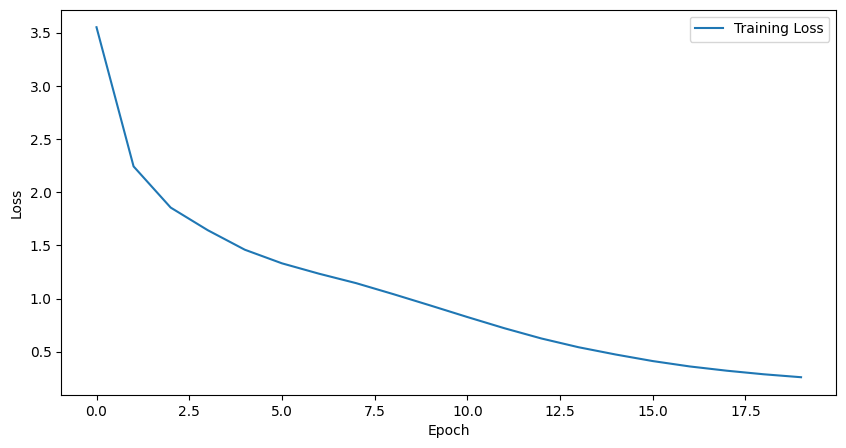

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
def train_script(model, train_loader, loss_fn, optimizer, n_epochs, device): 
    model.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    train_losses = []
    test_losses = []
    
    for epoch in tqdm(range(n_epochs), desc='Epochs'): 
        model.train()
        epoch_loss = 0
        for x, y in tqdm(train_loader, desc='Batches'): 
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x) 
            loss = loss_fn(y_pred.view(-1, vocab_len), y.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        train_losses.append(epoch_loss / len(train_loader))
        
        # evaluate the model on test data
        if (epoch + 1) % 10 == 0: 
            test_loss = eval_script(model, test_loader, loss_fn, device)
            test_losses.append(test_loss)
            print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}, Test Loss: {test_loss}")
        
            # if test loss is not decreasing, stop training
            if len(test_losses) > 1 and test_losses[-1] >= test_losses[-2]: 
                print("Test loss is not decreasing anymore. Stop training.")
                break     
            
        else: 
            print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
            if len(train_losses) > 1 and train_losses[-1] >= train_losses[-2]: 
                print("Training loss is not decreasing anymore. Stop training.")
                break
    
    # Plot the training and test loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    # plt.plot(range(9, n_epochs, 10), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model

def eval_script(model, test_loader, loss_fn, device): 
    model.eval()
    total_loss = 0
    with torch.no_grad(): 
        for x, y in test_loader: 
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred.view(-1, vocab_len), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(test_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 100

nano_gpt = train_script(nano_gpt, train_loader, loss_fn, optimizer, n_epochs, device)

In [12]:
# save model 
torch.save(nano_gpt.state_dict(), "nanoGPT.pth")

In [17]:
def generate_text(model, start_text, max_len, device): 
    model.eval()
    start_text = torch.tensor(encoder(start_text), dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad(): 
        for _ in range(max_len): 
            y_pred = model(start_text)
            y_pred = y_pred[:, -1, :]
            next_char = torch.argmax(y_pred, dim=-1).unsqueeze(0)
            start_text = torch.cat([start_text, next_char], dim=1)

            # check max length. 
            if len(start_text[0]) + 1 >= max_len:
                break
    return start_text

start_text = '12..Gia tư' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generated_text = generate_text(nano_gpt, start_text, max_len, device)
generated_text = generated_text.squeeze(0).cpu().numpy()
generated_text = decoder(generated_text)
print(generated_text)


12..Gia tư cũng thủy thưa qua,
Tiểu thư đâu đắm a dắm chẳng sai.
Cách hồng mai trông mặt cầu hai,
2680. Đầu thuyền chực bết kế chài giăng sông.
Một lòng chẳng quảng mấy công,
Khéo thay gặp gỡ cũng tro
